# Item Based Collaborative Filtering


Collaborative filtering based systems use the actions of users to recommend other items. In general, they can either be user based or item based. User based collaborating filtering uses the patterns of users similar to me to recommend a product (users like me also looked at these other items). Item based collaborative filtering uses the patterns of users who browsed the same item as me to recommend me a product (users who looked at my item also looked at these other items). Item-based approach is usually prefered than user-based approach. User-based approach is often harder to scale because of the dynamic nature of users, whereas items usually don't change much, so item-based approach often can be computed offline.

Let us see how well Collaborative Filter recommend a movie preference. We will go over our movie datasets, ML model choices, how to evaluate our recommender.
I will train a KNN model to pick similar movies based on user's ratings and make movie recommendation based on similarity score of previous rated movies.

In [40]:
import os
import pandas as pd
import numpy as np

# configure file path
#data_path = os.path.join(os.environ['DATA_PATH'], 'MovieLens')
movies_filename = 'movies.csv'
ratings_filename = 'ratings.csv'
# read data
df_movies = pd.read_csv(
    os.path.join(movies_filename),
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    os.path.join(ratings_filename),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [41]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [42]:
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


As seen above, I have selected MovieLens Datasets. It contains 27,753,444 ratings and 1,108,997 tag applications across 58,098 movies. These data were created by 283,228 users between January 09, 1995 and September 26, 2018. The ratings are on a scale from 1 to 5. 
 
We will use only two files from MovieLens datasets: ratings.csv & movies.csv. Ratings data provides the ratings of movies given by users. There are three fields in each row: ['userId', 'movieId', 'rating']. Each row can be seen as a record of interaction between a user and a movie. Movies data provides a movie title and genres for each 'movieId' in Ratings data.

# Ratings Frequnecy Plot

In a real world setting, data collected from explicit feedbacks like movie ratings can be very sparse and data points are mostly collected from very popular movies as they have high number of viewers. Large amount of less known movies don’t have ratings at all. Let’s see plot the distribution of movie rating frequency.

1. Simple way to begin would be by counting total ratings per type

In [43]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


Text(0,0.5,'number of ratings')

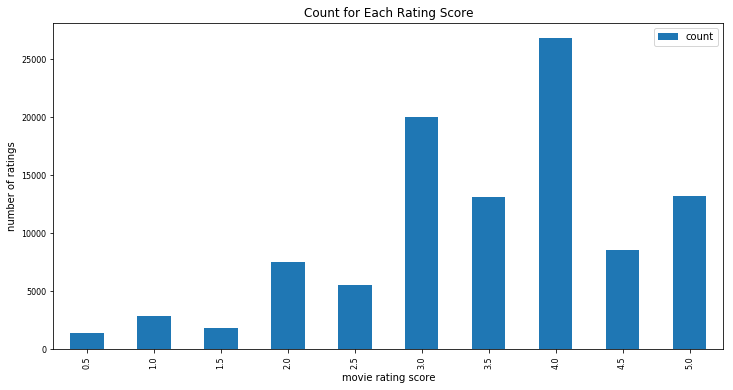

In [44]:
ax = df_ratings_cnt_tmp.plot(kind='bar',figsize=(12, 6),
    title='Count for Each Rating Score',fontsize=8)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

As we see the no of ppl giving ratings of 3 and 4 are more

2. Let us repeat the same step, but this time on a movie

In [45]:
df_movie_cnt_tmp = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['movie_count'])
df_movie_cnt_tmp.head()

,movie_count
movieId,
1,215
2,110
3,52
4,7
5,49


In [46]:
df_movie_cnt_tmp.shape

(9724, 1)

Text(0,0.5,'number of ratings')

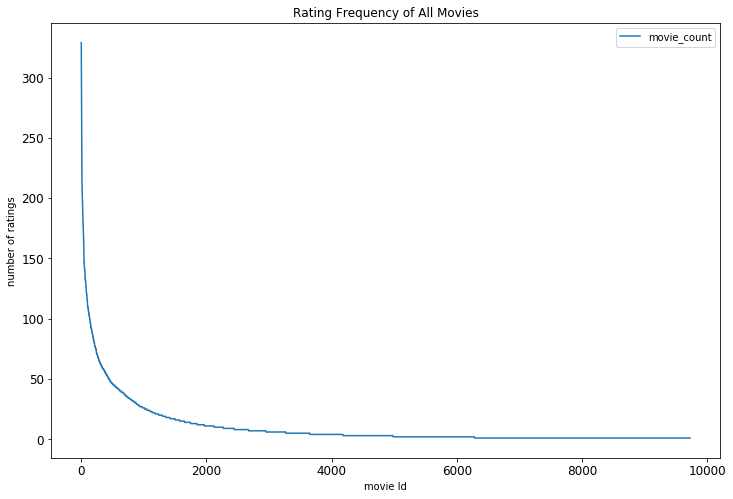

In [47]:
# plot rating frequency of all movies
ax = df_movie_cnt_tmp \
    .sort_values('movie_count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

The distribution of ratings among movies often satisfies a property in real-world settings, which is referred to as the long-tail property. According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items. The vast majority of items are rated rarely. This results in a highly skewed distribution of the underlying ratings.



Text(0,0.5,'number of ratings (log scale)')

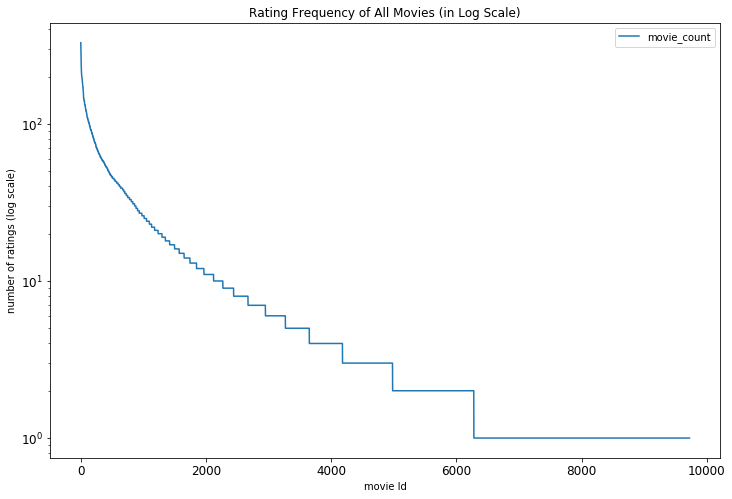

In [48]:
# plot rating frequency of all movies but this time with a log scale
ax = df_movie_cnt_tmp \
    .sort_values('movie_count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

we can see above that about 3000 movies of 10000 are been rated with an rating of 50 and Higher

Let us have a closer look at Quantile Ratings Counts

In [49]:
#df_movie_cnt_tmp['movie_count'].quantile(np.arange(1, 0.6, -0.05))
df_movie_cnt_tmp['movie_count'].quantile(np.arange(1,0.2,-0.05))

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
0.60      4.0
0.55      3.0
0.50      3.0
0.45      2.0
0.40      2.0
0.35      1.0
0.30      1.0
0.25      1.0
Name: movie_count, dtype: float64


So about 1% of movies have roughly 329 or more ratings, 5% have 47 or more, and 20% have 12 or more. Since we have so many movies, we'll limit it to the top 70%. This is arbitrary threshold for popularity, but it gives us about 7000 different movies. We still have pretty good amount of movies for modeling. There are two reasons why we want to filter to roughly 13,500 movies in our dataset.

Memory issue: we don't want to run into the “MemoryError” during model training
Improve KNN performance: lesser known movies have ratings from fewer viewers, making the pattern more noisy. Droping out less known movies can improve recommendation quality

In [50]:
# filter data
popularity_thres = 7
not_popular_movies = list(set(df_movie_cnt_tmp.query('movie_count <= @popularity_thres').index))
print(len(not_popular_movies))
print(not_popular_movies)

7053
[32770, 4, 131098, 30, 32799, 131104, 38, 40, 65577, 42, 49, 65585, 65588, 53, 54, 55, 98361, 131130, 65596, 61, 63, 64, 65601, 68, 71, 72, 75, 77, 78, 80, 83, 85, 163925, 87, 32862, 65631, 96, 163937, 99, 102, 103, 106, 32875, 108, 65642, 113, 65651, 116, 117, 118, 119, 121, 123, 32892, 126, 128, 129, 32898, 132, 137, 32906, 163981, 163985, 146, 32914, 148, 149, 32917, 65682, 152, 65685, 155, 156, 131237, 166, 171, 178, 179, 183, 184, 187, 189, 190, 191, 98499, 199, 98503, 201, 202, 65738, 65740, 206, 209, 210, 211, 212, 213, 214, 217, 219, 220, 228, 229, 238, 240, 241, 242, 243, 250, 251, 254, 255, 259, 263, 65802, 269, 270, 271, 274, 275, 65810, 278, 279, 98585, 283, 284, 285, 287, 291, 294, 295, 298, 299, 98604, 301, 302, 98607, 304, 310, 311, 313, 33085, 98623, 320, 321, 33090, 324, 325, 326, 98633, 330, 331, 334, 335, 336, 136838, 340, 341, 343, 346, 347, 65882, 352, 354, 33124, 33126, 359, 164200, 363, 33132, 365, 131439, 369, 33138, 33145, 378, 33148, 384, 385, 386, 387, 3

In [51]:
df_ratings.movieId

0              1
1              3
2              6
3             47
4             50
5             70
6            101
7            110
8            151
9            157
10           163
11           216
12           223
13           231
14           235
15           260
16           296
17           316
18           333
19           349
20           356
21           362
22           367
23           423
24           441
25           457
26           480
27           500
28           527
29           543
           ...  
100806    150401
100807    152077
100808    152081
100809    152372
100810    155064
100811    156371
100812    156726
100813    157296
100814    158238
100815    158721
100816    158872
100817    158956
100818    159093
100819    160080
100820    160341
100821    160527
100822    160571
100823    160836
100824    161582
100825    161634
100826    162350
100827    163937
100828    163981
100829    164179
100830    166528
100831    166534
100832    168248
100833    1682

In [52]:
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(not_popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data of unpopular movies to be dropped : ', df_ratings_drop_movies.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data of unpopular movies to be dropped :  (16332, 3)


In [53]:
df_ratings_pick_movies = df_ratings[~df_ratings.movieId.isin(not_popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_pick_movies.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping unpopular movies:  (84504, 3)


After dropping 70% of movies in our dataset, we still have a very large dataset. So next we can filter users to further reduce the size of data



In [54]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_pick_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,218
2,27
3,26
4,185
5,44


Text(0,0.5,'number of ratings')

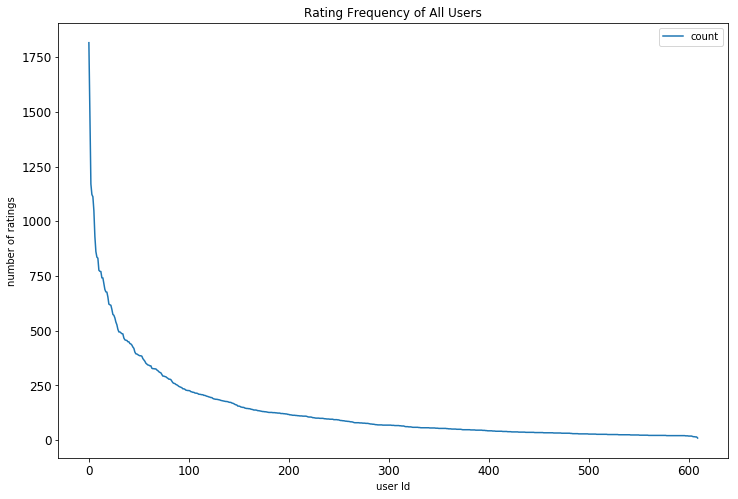

In [55]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [56]:
df_users_cnt['count'].quantile(np.arange(1, 0.3, -0.05))

1.00    1816.00
0.95     494.00
0.90     339.30
0.85     242.30
0.80     194.40
0.75     150.75
0.70     126.00
0.65     109.85
0.60      95.00
0.55      77.00
0.50      67.00
0.45      56.00
0.40      50.00
0.35      44.00
Name: count, dtype: float64

We can see that the distribution of ratings by users is very similar to the distribution of ratings among movies. They both have long-tail property. Only a very small fraction of users are very actively engaged with rating movies that they watched. Vast majority of users aren't interested in rating movies. So we can limit users to the top 40%, which is about 77,161 users.

In [57]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))


In [58]:
df_ratings_pick_movies.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [59]:
df_ratings_pick_users = df_ratings_pick_movies[df_ratings_pick_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_pick_users.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (77161, 3)


# Train KNN model for item-based collaborative filtering

Here we need to perform 2 task:
    
    1] DataSet Creation (Data formatting and Reshapping)
    
    2] Training the Model

Let us start with Dataset creation, for item based collaborative filtering we need our dataset to be in a format where each row has a label ie a movieid and column features with userId who have rated that movie, the columns where userId who havent rated a movie will be filled with 0, as we are going to calculate distance between vectors. In short, we are going to transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [60]:
df_ratings_pick_users

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0
6,1,101,5.0
7,1,110,4.0
8,1,151,5.0
9,1,157,5.0


In [61]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_pick_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movie_user_mat.head()

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


Need to map movie ids above with movie names

In [62]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [63]:
movie_to_idx = {
    movie: i for i, movie in  
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}

movie_to_idx

{'Toy Story (1995)': 0,
 'Jumanji (1995)': 1,
 'Grumpier Old Men (1995)': 2,
 'Father of the Bride Part II (1995)': 3,
 'Heat (1995)': 4,
 'Sabrina (1995)': 5,
 'Tom and Huck (1995)': 6,
 'Sudden Death (1995)': 7,
 'GoldenEye (1995)': 8,
 'American President, The (1995)': 9,
 'Dracula: Dead and Loving It (1995)': 10,
 'Balto (1995)': 11,
 'Nixon (1995)': 12,
 'Cutthroat Island (1995)': 13,
 'Casino (1995)': 14,
 'Sense and Sensibility (1995)': 15,
 'Four Rooms (1995)': 16,
 'Ace Ventura: When Nature Calls (1995)': 17,
 'Money Train (1995)': 18,
 'Get Shorty (1995)': 19,
 'Copycat (1995)': 20,
 'Assassins (1995)': 21,
 'Powder (1995)': 22,
 'Leaving Las Vegas (1995)': 23,
 'Othello (1995)': 24,
 'Now and Then (1995)': 25,
 'Persuasion (1995)': 26,
 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': 27,
 'Dangerous Minds (1995)': 28,
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 29,
 'Babe (1995)': 30,
 'Dead Man Walking (1995)': 31,
 'Clueless (1995)': 32,
 'Richard III 

In [64]:
movie_user_mat.head()

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


In [65]:
# transform matrix to scipy sparse matrix
from scipy.sparse import csr_matrix

movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

Training time,I will now fit our sparse matrix using KNN model, By specifying the metric = cosine, the model will measure similarity bectween artist vectors by using cosine similarity.

In [109]:
from sklearn.neighbors import NearestNeighbors

%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=20, p=2, radius=1.0)

In [89]:
distances, indices = model_knn.kneighbors(movie_user_mat_sparse[1],5)


In [115]:
from fuzzywuzzy import fuzz

def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



In [116]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [118]:
my_favorite = 'BatMan'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: BatMan
Found possible matches in our database: ['Batman (1989)']

Recommendation system start to make inference
......

Recommendations for BatMan:
1: Die Hard: With a Vengeance (1995), with distance of 0.3967081308364868
2: Aladdin (1992), with distance of 0.39233124256134033
3: Braveheart (1995), with distance of 0.387675404548645
4: Speed (1994), with distance of 0.3858727216720581
5: Mask, The (1994), with distance of 0.36768609285354614
6: Fugitive, The (1993), with distance of 0.35115867853164673
7: Jurassic Park (1993), with distance of 0.32986515760421753
8: Terminator 2: Judgment Day (1991), with distance of 0.3072262406349182
9: Batman Forever (1995), with distance of 0.3037834167480469
10: True Lies (1994), with distance of 0.29958897829055786
